# Biomedical Imaging 4C16/5C16 Project

## Tumor Segmentation & Classification

#### About the dataset

You have been given a dataset of ultrasound scans and segmentation maps associated with these ultrasound scans. These scans are to be used for training networks for ***breast cancer tumor segmentation and classification***.

The dataset has already been prepared to numpy files and is in the 'dataset' directory and is of the following structure:

- *dataset/*
    - *benign/*
        - *input.npy*
        - *target.npy*
    - *malignant/*
        - *input.npy*
        - *target.npy*
    - *normal/*
        - *input.npy*
        - *target.npy*

The *input.npy* and *output.npy* files are the input ultrasound scans and target segmentation maps for that tumor category (benign, malignant, normal).

- All input ultrasound scans are images of size 128x128x3. This means the height and width of these images are 128 and it is stored in RGB space. The pixels range from 0-1.
- All segmentation maps are images of size 128x128x1. This is an image where a value of 1 means that a tumor is detected at that location, and 0 means there is no tumor present.

The code block below displays examples of ultrasound scans and tumor segmentation maps for these image pairs.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-06/

Mounted at /content/gdrive
/content/gdrive/MyDrive/4c16-labs/code/lab-06


In [ ]:
# Function to save a model
def save_model_to_disk(model, filename_base):
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open(filename_base + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{filename_base}.h5")
    print("Saved model to model.json and weights to model.h5")

In [ ]:
# Download the dataset
!curl --create-dirs -o /home/tcd/data/medicalimaging-dataset.zip https://tcddeeplearning.blob.core.windows.net/deeplearning202324/medicalimaging-dataset.zip

!mkdir -p /home/tcd/data/medicalimaging/
!unzip -o /home/tcd/data/medicalimaging-dataset.zip -d /home/tcd/data/medicalimaging/

# Dataset is located in /home/tcd/data/medicalimaging/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.1M  100 16.1M    0     0  3209k      0  0:00:05  0:00:05 --:--:-- 3918k
Archive:  /home/tcd/data/medicalimaging-dataset.zip
  inflating: /home/tcd/data/medicalimaging/dataset/normal/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/malignant/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/benign/target.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/benign/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/malignant/target.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/normal/target.npy  


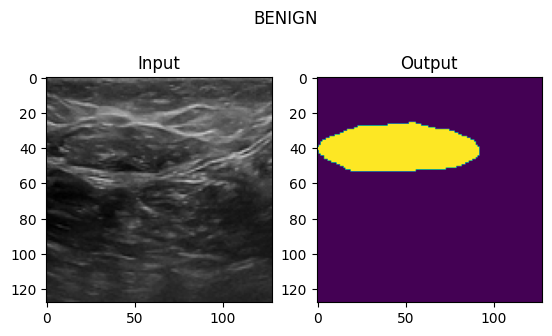

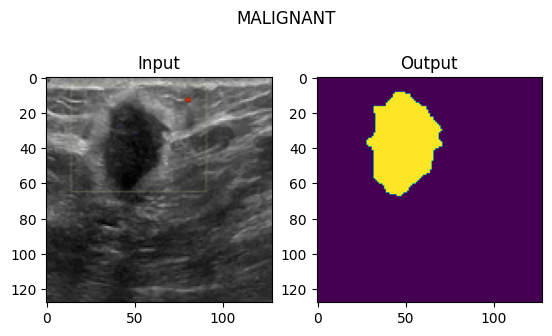

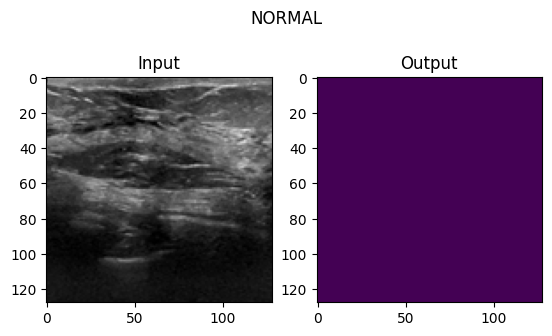

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

for _type in ['benign', 'malignant', 'normal']:
    X = np.load(f'/home/tcd/data/medicalimaging/dataset/{_type}/input.npy')
    y = np.load(f'/home/tcd/data/medicalimaging/dataset/{_type}/target.npy')
    randomExample = random.randint(0, X.shape[0] - 1)
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(X[randomExample])
    axs[0].title.set_text('Input')
    axs[1].imshow(y[randomExample])
    axs[1].title.set_text('Output')
    fig.suptitle(_type.upper())
    plt.subplots_adjust(top=1.1)
    plt.show()

### The problem

You are required to train two separate neural networks for the purposes of:

1. **Classification Task**: Predicting whether an ultrasound is a) benign tumor,  b) contains a malignant tumor or c) normal (no-tumor).
    - Input are ultra sound scans (data from benign/malignant/normal), the output is a vector of the 3 probabilities for the classes (benign/malignant/normal) in that order (eg. [0.01, 0.99, 0] means the outcome is more likely to be malignant).
2. **Segmentation Task**: Predicting the segmentation map for a tumor of an input MRI scan if a tumor exists
    - Input are ultra sound scans (data from benign/malignant/normal), output is an image with the same height and width as the input image, but with only one channel and a value of 1 over the location where a tumor is present.

---

*IMPORTANT*

For Task 1, your model should be created with the name: 'classification_model',
the model size should be under 5M

For Task 2, your model should be created with the name: 'segmentation_model',
the model size should be under 3M.

In [ ]:
# Hints:
#
# Load data into appropriate input/output formats.
# For example, for problem 1:
#   * inputs should be a collection of images of size [n_samples x height x width x 3],
#   * outputs should be of size [n_samples x height x width x 1].
#
# Load images using the `np.load` function. You can combine tensors using `np.concat`
# to form a single input or output dataset tensor. Look at previous labs for inspiration
# on what datasets look like.
#
# The amount of training data is very low, so usage of data
# augmentation techniques is strongly advised.(eg. see tf.keras.layers.RandomRotation)
#
# Classification Task hint: you may also think of using pre-trained networks
# with fine-tuning.
# Keep the model size under the restriction of 5Million parameters, you should
# be able to hit the target at much less model size. (Lower the better:))
#
# Segmentation Task hint: You might want to use transpose convolution layers to go up in tensor size.
# Popular segmentation architectures include U-Net (with skip-connections) or DnCNN.
# Keep the model size under the restriction of 3 Million parameters, you should
# be able to hit the target at very much lower model size. (Lower the better:))

In [ ]:
## Loading the data
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Define paths to the dataset
dataset_path = '/home/tcd/data/medicalimaging/dataset/'

## Load data for classification task
benign_X = np.load(dataset_path + 'benign/input.npy')
malignant_X = np.load(dataset_path + 'malignant/input.npy')
normal_X = np.load(dataset_path + 'normal/input.npy')

# Combine data
X_classification = np.concatenate((benign_X, malignant_X, normal_X), axis=0)

# Load labels for classification task
benign_y = to_categorical(np.zeros(benign_X.shape[0]), num_classes=3)  # Class label for benign is [1, 0, 0]
malignant_y = to_categorical(np.ones(malignant_X.shape[0]), num_classes=3)  # Class label for malignant is [0, 1, 0]
normal_y = to_categorical(2 * np.ones(normal_X.shape[0]), num_classes=3)  # Class label for normal is [0, 0, 1]

# Combine labels
y_classification = np.concatenate((benign_y, malignant_y, normal_y), axis=0)

# Split data into training and validation sets for classification
X_train_classification, X_val_classification, y_train_classification, y_val_classification = train_test_split(
    X_classification, y_classification, test_size=0.2, random_state=42
)

## Load data for segmentation task
benign_seg_y = np.load(dataset_path + 'benign/target.npy')
malignant_seg_y = np.load(dataset_path + 'malignant/target.npy')
normal_seg_y = np.load(dataset_path + 'normal/target.npy')

# Combine segmentation data
X_segmentation = np.concatenate((benign_X, malignant_X, normal_X), axis=0)
y_segmentation = np.concatenate((benign_seg_y, malignant_seg_y, normal_seg_y), axis=0)

# Split data into training and validation sets for segmentation
X_train_segmentation, X_val_segmentation, y_train_segmentation, y_val_segmentation = train_test_split(
    X_segmentation, y_segmentation, test_size=0.2, random_state=42
)

# Display the shapes of the training and validation sets to check if they are in appropriate formats
print("Classification Task:")
print("X_train shape:", X_train_classification.shape)
print("y_train shape:", y_train_classification.shape)
print("X_val shape:", X_val_classification.shape)
print("y_val shape:", y_val_classification.shape)

print("\nSegmentation Task:")
print("X_train shape:", X_train_segmentation.shape)
print("y_train shape:", y_train_segmentation.shape)
print("X_val shape:", X_val_segmentation.shape)
print("y_val shape:", y_val_segmentation.shape)


Classification Task:
X_train shape: (560, 128, 128, 3)
y_train shape: (560, 3)
X_val shape: (141, 128, 128, 3)
y_val shape: (141, 3)

Segmentation Task:
X_train shape: (560, 128, 128, 3)
y_train shape: (560, 128, 128, 1)
X_val shape: (141, 128, 128, 3)
y_val shape: (141, 128, 128, 1)


In [ ]:
import matplotlib.pyplot as plt
# Function for plotting training history - Based on Accuracy
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Show the plots
    plt.show()

# Function for plotting training history - Based on F1 Score
def plot_segmentation_history(history):
    # Plot training & validation F1 score values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('Model F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Show the plots
    plt.show()

In [ ]:
# Necessary imports for defining the model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Flatten, Dense, Dropout, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.optimizers import Adam


In [ ]:
# Classification Model
def create_classification_model():
  # Using MobileNetV2 (Comparitively produces less params than VGG16)
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

  # Keep the initial layers of the predefined layer fixed - Freezing
  for layer in base_model.layers:
    layer.trainable = False

  # Create a custom layer for final classification decisions
  flat = Flatten()(base_model.output)
  dense1 = Dense(128, activation='relu')(flat)
  dropout = Dropout(0.5)(dense1)
  # Using softmax for classification
  output_classification = Dense(3, activation='softmax', name='output_classification')(dropout)

  # Create the model
  model = Model(inputs=base_model.input, outputs=output_classification)

  # Print model summary
  model.summary()

  return model

classification_model = create_classification_model()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [ ]:
from tensorflow.keras import backend as K

# Define a function to calculate F1 score
def f1_score(y_true, y_pred):
    # Flatten the tensors
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(K.round(y_pred))

    # True positives, false positives, and false negatives
    tp = K.sum(y_true_flat * y_pred_flat)
    fp = K.sum((1 - y_true_flat) * y_pred_flat)
    fn = K.sum(y_true_flat * (1 - y_pred_flat))

    # Precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # F1 score (harmonic mean of precision and recall)
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1


In [ ]:
# Segmentation Model
def create_segmentation_model():
    input_shape = (128, 128, 3)

    # Input layer
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Middle
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)

    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = Conv2D(64, (2, 2), activation='relu', padding='same', kernel_initializer='he_normal')(up4)
    up4 = BatchNormalization()(up4)
    merge4 = concatenate([conv2, up4])
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(merge4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(32, (2, 2), activation='relu', padding='same', kernel_initializer='he_normal')(up5)
    up5 = BatchNormalization()(up5)
    merge5 = concatenate([conv1, up5])
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(merge5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    # Model
    model = Model(inputs=inputs, outputs=outputs)

    # Print Model Summary
    model.summary()

    return model

segmentation_model = create_segmentation_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 128, 128, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d_18[0][0]']           
 Normalization)                                                                                   
                                                                                                  
 conv2d_19 (Conv2D)          (None, 128, 128, 64)         36928     ['batch_normalization[0]

In [ ]:
# A Different U-Net Architecture to improve F1-Score - 0.72
def create_segmentation_model():
    input_shape = (128, 128, 3)
    l2_reg = 0.0001
    dropout_rate = 0.5
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg))(inputs)
    conv1 = LeakyReLU(alpha=0.01)(conv1)
    conv1 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg))(conv1)
    conv1 = LeakyReLU(alpha=0.01)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg))(pool1)
    conv2 = LeakyReLU(alpha=0.01)(conv2)
    conv2 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg))(conv2)
    conv2 = LeakyReLU(alpha=0.01)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg))(pool2)
    conv3 = LeakyReLU(alpha=0.01)(conv3)
    conv3 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg))(conv3)
    conv3 = LeakyReLU(alpha=0.01)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom
    conv4 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg))(pool3)
    conv4 = LeakyReLU(alpha=0.01)(conv4)
    conv4 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg))(conv4)
    conv4 = LeakyReLU(alpha=0.01)(conv4)

    # Adding Dropout
    conv4 = Dropout(dropout_rate)(conv4)

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(128, 2, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg))(up5)
    up5 = LeakyReLU(alpha=0.01)(up5)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg))(merge5)
    conv5 = LeakyReLU(alpha=0.01)(conv5)
    conv5 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg))(conv5)
    conv5 = LeakyReLU(alpha=0.01)(conv5)

    # Adding Dropout
    conv5 = Dropout(dropout_rate)(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(64, 2, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg))(up6)
    up6 = LeakyReLU(alpha=0.01)(up6)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg))(merge6)
    conv6 = LeakyReLU(alpha=0.01)(conv6)
    conv6 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg))(conv6)
    conv6 = LeakyReLU(alpha=0.01)(conv6)

    # Adding Dropout
    conv6 = Dropout(dropout_rate)(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(32, 2, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg))(up7)
    up7 = LeakyReLU(alpha=0.01)(up7)
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg))(merge7)
    conv7 = LeakyReLU(alpha=0.01)(conv7)
    conv7 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg))(conv7)
    conv7 = LeakyReLU(alpha=0.01)(conv7)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)

    model.summary()

    return model

segmentation_model = create_segmentation_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 32)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['leaky_re_lu[0][0]']         
                                                                                              

In [ ]:
# Necessary Imports for Training the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import binary_crossentropy

# Augmentation with Random Rotation
datagen = ImageDataGenerator(rotation_range=20, fill_mode='nearest')

Epoch 1/20
18/17 [==============================] - ETA: 0s - loss: 0.7224 - accuracy: 0.7018
Epoch 1: val_accuracy improved from -inf to 0.75887, saving model to classification_model_best_weights.h5
17/17 [==============================] - 7s 217ms/step - loss: 0.7224 - accuracy: 0.7018 - val_loss: 0.5592 - val_accuracy: 0.7589
Epoch 2/20
18/17 [==============================] - ETA: 0s - loss: 0.6648 - accuracy: 0.6893
Epoch 2: val_accuracy did not improve from 0.75887
17/17 [==============================] - 2s 125ms/step - loss: 0.6648 - accuracy: 0.6893 - val_loss: 0.5251 - val_accuracy: 0.7447
Epoch 3/20
18/17 [==============================] - ETA: 0s - loss: 0.6261 - accuracy: 0.7036
Epoch 3: val_accuracy did not improve from 0.75887
17/17 [==============================] - 3s 185ms/step - loss: 0.6261 - accuracy: 0.7036 - val_loss: 0.6053 - val_accuracy: 0.7305
Epoch 4/20
18/17 [==============================] - ETA: 0s - loss: 0.6085 - accuracy: 0.7071
Epoch 4: val_accuracy d

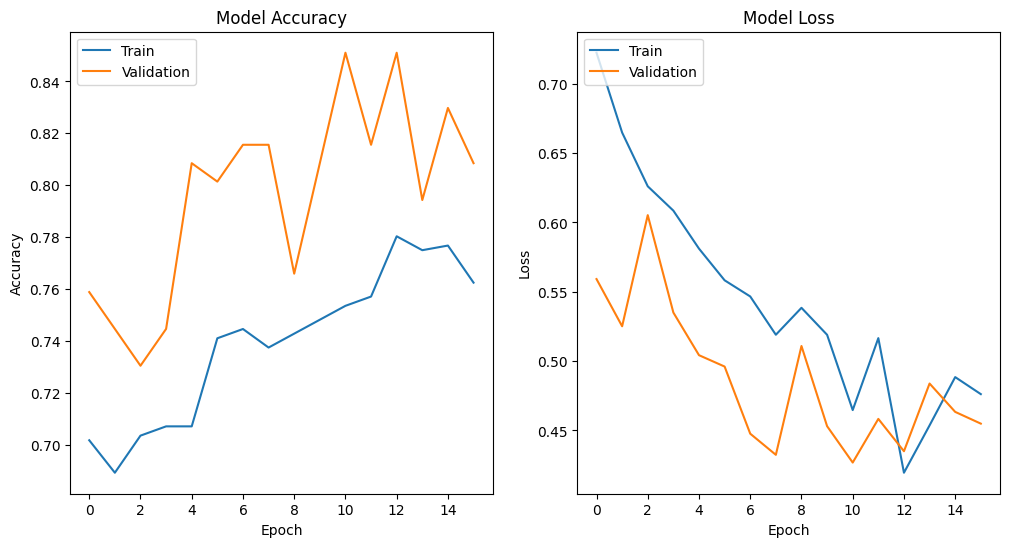

5/5 [==============================] - 0s 21ms/step - loss: 0.4268 - accuracy: 0.8511
Validation Accuracy: 85.11%


In [ ]:
# Compile the classification model
classification_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ModelCheckpoint to save the best weights during training - Benefical if the accuracy start to decrease after certain epochs
checkpoint = ModelCheckpoint("classification_model_best_weights.h5", save_best_only=True, save_weights_only=True, mode='max', monitor='val_accuracy', verbose=1)

# EarlyStopping to stop training if the validation accuracy doesn't improve
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model with data augmentation
history = classification_model.fit(
    datagen.flow(X_train_classification, y_train_classification, batch_size=32),
    steps_per_epoch=len(X_train_classification) / 32,
    epochs=20,
    validation_data=(X_val_classification, y_val_classification),
    callbacks=[checkpoint, early_stopping]
)

# Plot the graph showing training history
plot_training_history(history)

# Evaluate on the validation set
val_loss, val_accuracy = classification_model.evaluate(X_val_classification, y_val_classification)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


Epoch 1/10
17/17 [==============================] - 11s 259ms/step - loss: 0.1355 - f1_score: 0.7016 - val_loss: 0.1937 - val_f1_score: 0.6914
Epoch 2/10
17/17 [==============================] - 5s 266ms/step - loss: 0.1178 - f1_score: 0.7537 - val_loss: 0.1811 - val_f1_score: 0.7111
Epoch 3/10
17/17 [==============================] - 5s 262ms/step - loss: 0.1094 - f1_score: 0.7854 - val_loss: 0.1788 - val_f1_score: 0.7178
Epoch 4/10
17/17 [==============================] - 4s 228ms/step - loss: 0.1130 - f1_score: 0.7759 - val_loss: 0.2006 - val_f1_score: 0.6765
Epoch 5/10
17/17 [==============================] - 4s 239ms/step - loss: 0.1076 - f1_score: 0.7822 - val_loss: 0.1891 - val_f1_score: 0.7009
Epoch 6/10
17/17 [==============================] - 5s 269ms/step - loss: 0.1110 - f1_score: 0.7839 - val_loss: 0.1957 - val_f1_score: 0.6939
Epoch 7/10
17/17 [==============================] - 4s 235ms/step - loss: 0.1136 - f1_score: 0.7713 - val_loss: 0.1864 - val_f1_score: 0.7048
Epoch

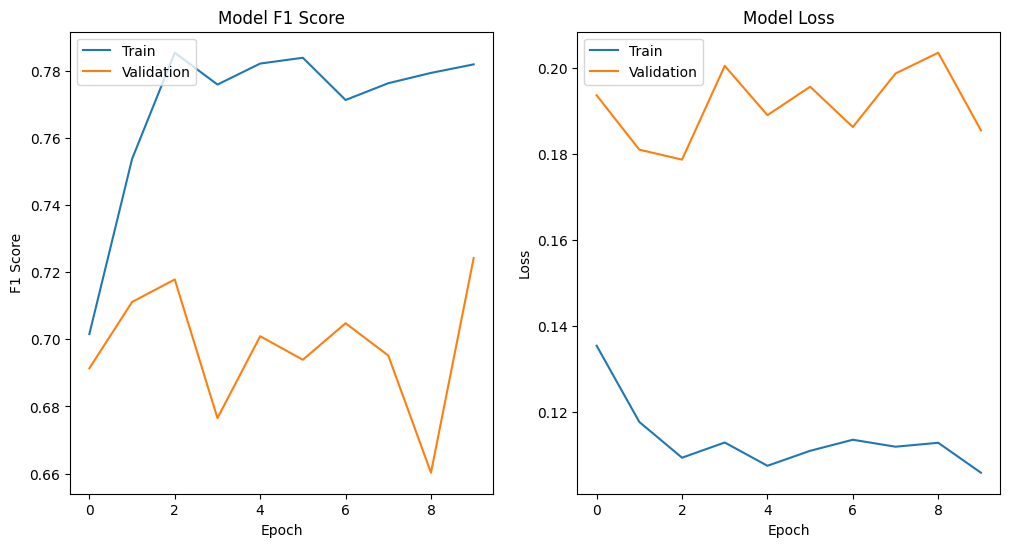

5/5 [==============================] - 0s 51ms/step - loss: 0.1856 - f1_score: 0.7242
Validation Loss: 0.1855907291173935, Validation F1 Score: 0.7242310047149658


In [ ]:
# Compile the segmentation model with F1 score as a metric
adam_optimizer = Adam(learning_rate=0.001)
segmentation_model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=[f1_score])

# Train the model with the data augmentation
history = segmentation_model.fit(
    datagen.flow(X_train_segmentation, y_train_segmentation, batch_size=32),
    steps_per_epoch=len(X_train_segmentation) / 32,
    epochs=10,
    validation_data=(X_val_segmentation, y_val_segmentation))


# Plot the graph showing training history
plot_segmentation_history(history)

# Evaluate on the validation set with F1 score
val_loss, val_f1 = segmentation_model.evaluate(X_val_segmentation, y_val_segmentation)
print(f"Validation Loss: {val_loss}, Validation F1 Score: {val_f1}")

In [ ]:
if (classification_model.count_params()  < 5000000) :
  save_model_to_disk(classification_model, "classification_model")
else:
  print("Your model is unecessarily complex, scale down!")

Saved model to model.json and weights to model.h5


In [ ]:
if (segmentation_model.count_params()  < 3000000) :
  save_model_to_disk(segmentation_model, "segmentation_model")
else:
  print("Your model is unecessarily complex, scale down!")

Saved model to model.json and weights to model.h5
